# 🚲 따릉이 데이터 분석 실습
이 노트북에서는 서울시 공공자전거(따릉이) 데이터를 활용하여 시간대별, 지역구별, 그리고 시간+지역구 복합 분석을 진행합니다.

In [116]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import glob

# 한글 폰트 설정 (Windows: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [117]:
# 데이터 불러오기 (컬럼명 반영)
csv_files = sorted(glob.glob('./data/bike_rent_*.csv'))
# 1~6번 파일만 사용
csv_files = [f for f in csv_files if any(f.endswith(f'bike_rent_{i}.csv') for i in range(1,7))]

rent_df_list = [pd.read_csv(f, encoding='utf-8') for f in csv_files]
rent_df = pd.concat(rent_df_list, ignore_index=True)

# 컬럼명 확인 및 한글 컬럼명으로 변경 (필요시)
rent_df.columns = ['자전거번호', '대여일시', '대여소번호', '대여소명', '이용시간(분)', '이용거리(m)']

# location_df 컬럼명 반영 및 '지역구' 생성
location_df = pd.read_excel('./data/bike_rent_location.xlsx')
location_df.columns = ['구분', '대여소번호', '대여소명', '위도', '경도', '거치대수']
# '구분' 컬럼을 '지역구'로 사용
location_df = location_df.rename(columns={'구분': '지역구'})

# 데이터 확인
print(rent_df.head())
print(location_df.head())

       자전거번호             대여일시  대여소번호               대여소명  이용시간(분)  이용거리(m)
0  SPB-22040  2019-06-03 8:49    646  장한평역 1번출구 (국민은행앞)       27     1330
1  SPB-07446  2019-06-03 8:33    526           용답토속공원 앞       54     1180
2  SPB-20387  2019-06-05 8:27    646  장한평역 1번출구 (국민은행앞)       12     1930
3  SPB-16794  2019-06-05 8:46    646  장한평역 1번출구 (국민은행앞)        6     1340
4  SPB-18266  2019-06-10 8:27    529       장한평역 8번 출구 앞        5     1230
   지역구  대여소번호              대여소명         위도          경도  거치대수
0  마포구    101  101. (구)합정동 주민센터  37.549561  126.905754     5
1  마포구    102   102. 망원역 1번출구 앞  37.556000  126.910454    20
2  마포구    103   103. 망원역 2번출구 앞  37.554951  126.910835    14
3  마포구    104   104. 합정역 1번출구 앞  37.550629  126.914986    13
4  마포구    105   105. 합정역 5번출구 앞  37.550007  126.914825     5


In [118]:
print(rent_df.shape[0])
print(rent_df.shape[1])
print(rent_df.index)
print(rent_df.columns)
print(rent_df.dtypes)
rent_df.info()

2215632
6
RangeIndex(start=0, stop=2215632, step=1)
Index(['자전거번호', '대여일시', '대여소번호', '대여소명', '이용시간(분)', '이용거리(m)'], dtype='object')
자전거번호      object
대여일시       object
대여소번호       int64
대여소명       object
이용시간(분)     int64
이용거리(m)     int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215632 entries, 0 to 2215631
Data columns (total 6 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   자전거번호    object
 1   대여일시     object
 2   대여소번호    int64 
 3   대여소명     object
 4   이용시간(분)  int64 
 5   이용거리(m)  int64 
dtypes: int64(3), object(3)
memory usage: 101.4+ MB


In [119]:
rent_df.describe()

대여소번호       이용시간(분)       이용거리(m)
count  2.215632e+06  2.215632e+06  2.215632e+06
mean   1.226154e+03  2.716998e+01  3.912916e+03
std    8.499197e+02  2.908119e+01  5.145471e+03
min    3.000000e+00  1.000000e+00  0.000000e+00
25%    5.050000e+02  8.000000e+00  1.220000e+03
50%    1.159000e+03  1.700000e+01  2.270000e+03
75%    1.846000e+03  3.700000e+01  4.670000e+03
max    9.998000e+03  3.133000e+03  2.323100e+05

## 1️⃣ 시간대별 이용 건수 및 이용 시간 분석
- '대여일시' 컬럼을 datetime으로 변환하고, 시간(hour) 컬럼을 생성합니다.
- 시간대별로 이용 건수와 총 이용시간을 집계합니다.

In [120]:
# '대여일시'를 datetime으로 변환 및 시간, 요일 컬럼 생성
rent_df['대여일시'] = pd.to_datetime(rent_df['대여일시'])
rent_df['hour'] = rent_df['대여일시'].dt.hour
# 요일 컬럼 추가 (0=월, 6=일 → 한글 요일명)
weekday_map = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
rent_df['요일'] = rent_df['대여일시'].apply(lambda x: weekday_map[x.weekday()])
rent_df

자전거번호                대여일시  대여소번호               대여소명  이용시간(분)  \
0        SPB-22040 2019-06-03 08:49:00    646  장한평역 1번출구 (국민은행앞)       27   
1        SPB-07446 2019-06-03 08:33:00    526           용답토속공원 앞       54   
2        SPB-20387 2019-06-05 08:27:00    646  장한평역 1번출구 (국민은행앞)       12   
3        SPB-16794 2019-06-05 08:46:00    646  장한평역 1번출구 (국민은행앞)        6   
4        SPB-18266 2019-06-10 08:27:00    529       장한평역 8번 출구 앞        5   
...            ...                 ...    ...                ...      ...   
2215627  SPB-22438 2019-06-24 07:40:00    240         문래역 4번출구 앞       13   
2215628  SPB-24455 2019-06-25 07:34:00    240         문래역 4번출구 앞        6   
2215629  SPB-24557 2019-06-26 08:19:00    240         문래역 4번출구 앞        7   
2215630  SPB-00649 2019-06-27 07:38:00    240         문래역 4번출구 앞       11   
2215631  SPB-14209 2019-06-28 07:37:00    240         문래역 4번출구 앞        6   

         이용거리(m)  hour 요일  
0           1330     8  월  
1           1180     8  월  
2           1930     8  수  
3           1340     8  수  
4           1230     8  월  
...          ...   ... ..  
2215627      900     7  월  
2215628      880     7  화  
2215629      930     8  수  
2215630     1030     7  목  
2215631     1010     7  금  

[2215632 rows x 8 columns]

In [121]:
# 시간대별 이용 건수 및 총 이용시간 집계
time_stats = rent_df.groupby('hour').agg(
    이용건수=('대여일시', 'count'),
    총이용시간=('이용시간(분)', 'sum')
).reset_index()
time_stats.head()

hour   이용건수    총이용시간
0     0  74628  1751617
1     1  56956  1315661
2     2  40981   929785
3     3  30747   679270
4     4  17751   374703

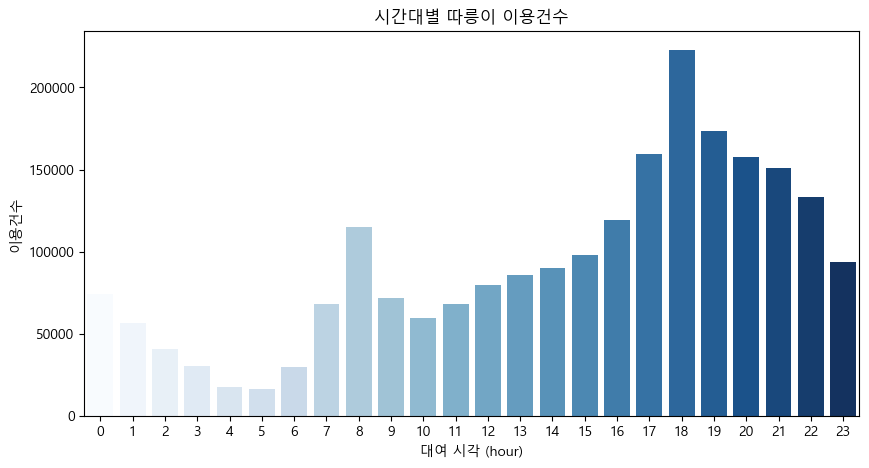

In [122]:
# 시간대별 따릉이 이용건수 barplot 시각화
plt.figure(figsize=(10,5))
sns.barplot(data=time_stats, x='hour', y='이용건수', palette='Blues', hue='hour', legend=False)
plt.title('시간대별 따릉이 이용건수')
plt.xlabel('대여 시각 (hour)')
plt.ylabel('이용건수')
plt.show()

## 2️⃣ 지역구 정보 병합 및 지역구별 분석
- 대여소 번호를 기준으로 대여 데이터와 대여소 정보를 병합합니다.
- 지역구별로 이용건수, 총 이용시간, 평균 이용시간을 집계합니다.

In [123]:
# 대여소 번호 기준으로 병합 (컬럼명 일치 보장)
merged = pd.merge(
    rent_df,
    location_df[['대여소번호', '지역구']],
    left_on='대여소번호',
    right_on='대여소번호',
    how='left'
)

In [124]:
# 지역구별 통계 집계
gu_stats = merged.groupby('지역구').agg(
    이용건수=('대여일시', 'count'),
    총이용시간=('이용시간(분)', 'sum'),
    평균이용시간=('이용시간(분)', 'mean')
).reset_index()
gu_stats = gu_stats.sort_values('이용건수', ascending=False)
gu_stats.head()

지역구    이용건수    총이용시간     평균이용시간
17   송파구  189706  5283816  27.852656
19  영등포구  179439  5287205  29.465194
12   마포구  158539  4860830  30.660153
5    광진구  141996  3543184  24.952703
3    강서구  141006  3263234  23.142519

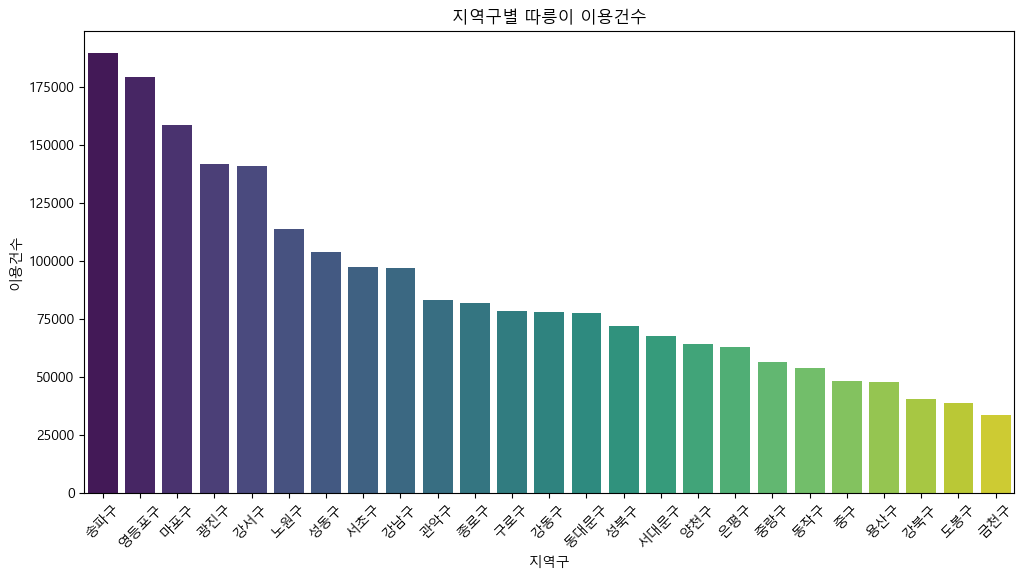

In [125]:
# 지역구별 이용건수 barplot
plt.figure(figsize=(12,6))
sns.barplot(data=gu_stats, x='지역구', y='이용건수', palette='viridis', hue='지역구', legend=False)
plt.title('지역구별 따릉이 이용건수')
plt.xlabel('지역구')
plt.ylabel('이용건수')
plt.xticks(rotation=45)
plt.show()

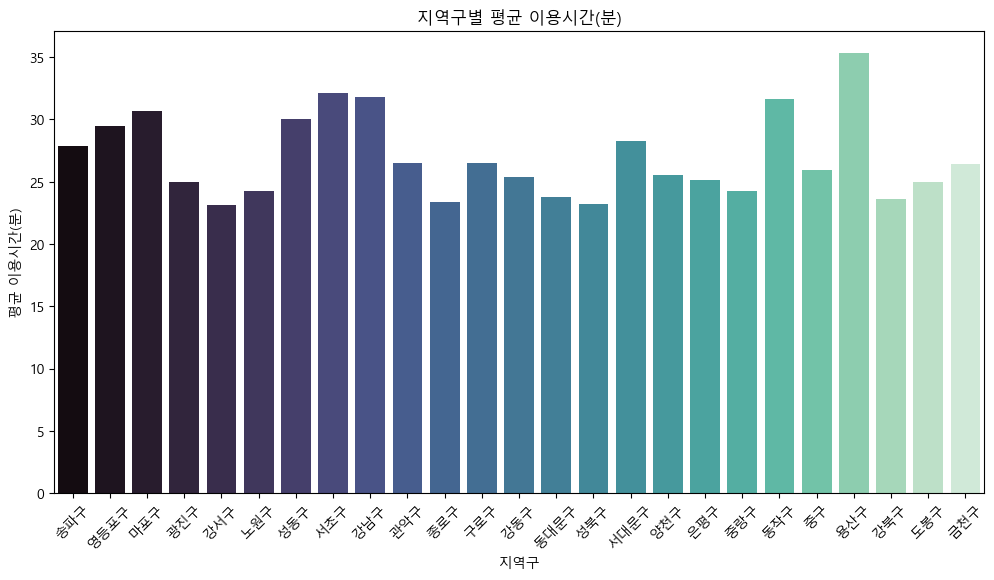

In [126]:
# 지역구별 평균 이용시간 barplot
plt.figure(figsize=(12,6))
sns.barplot(data=gu_stats, x='지역구', y='평균이용시간', palette='mako', hue='지역구', legend=False)
plt.title('지역구별 평균 이용시간(분)')
plt.xlabel('지역구')
plt.ylabel('평균 이용시간(분)')
plt.xticks(rotation=45)
plt.show()

## 3️⃣ 시간대 + 지역구 복합 분석 (피벗 테이블 & 히트맵)
- 시간(hour)과 지역구별로 피벗 테이블을 만들고, heatmap으로 시각화합니다.

In [127]:
# 시간대+지역구별 이용건수 피벗 테이블
pivot = merged.pivot_table(
    index='지역구', columns='hour', values='대여일시', aggfunc='count', fill_value=0
)
pivot.head()

hour    0     1     2     3     4     5     6     7     8     9   ...    14  \
지역구                                                               ...         
강남구   2643  2660  2360  1689   920   648  1316  2404  4951  3202  ...  3948   
강동구   3230  2342  1852  1398   620   686  1173  2420  3728  2413  ...  3103   
강북구   2066  1706  1378   932   595   392   499  1047  1533  1160  ...  1572   
강서구   4459  3306  2442  1909  1152  1072  2144  4854  9357  4766  ...  5474   
관악구   3769  2830  1899  1550   990   745  1042  2800  4350  2414  ...  2960   

hour    15    16    17     18     19     20    21    22    23  
지역구                                                            
강남구   4448  5468  8318  12630   7688   6161  5608  4544  3159  
강동구   3469  3943  5046   6298   5946   5638  5509  5147  4050  
강북구   1656  2037  2418   3119   2791   2730  2902  2728  2181  
강서구   5579  6843  9718  14674  11199  10342  9737  8248  5697  
관악구   3114  3925  4995   6710   6365   6350  6370  5861  4601  

[5 rows x 24 columns]

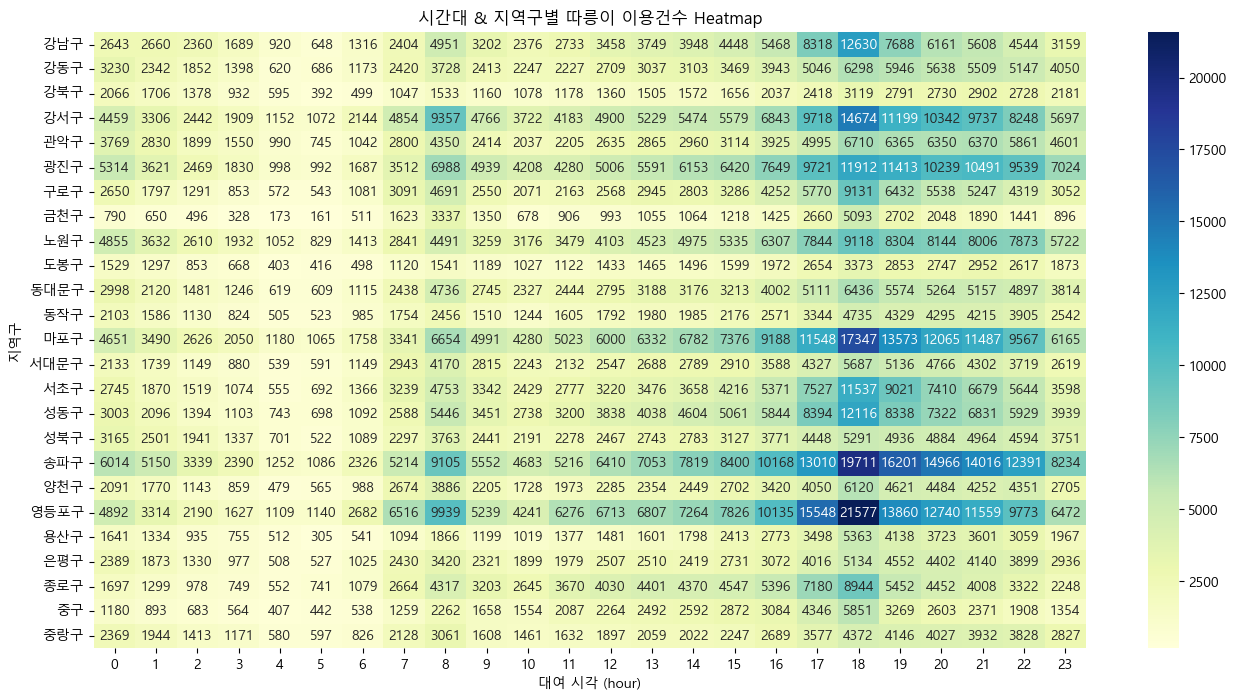

In [128]:
# heatmap 시각화
plt.figure(figsize=(16,8))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='d')
plt.title('시간대 & 지역구별 따릉이 이용건수 Heatmap')
plt.xlabel('대여 시각 (hour)')
plt.ylabel('지역구')
plt.show()

## 4️⃣ 대여소 위치 시각화 (Folium 지도)
- folium을 사용해 대여소 위치를 지도에 시각화합니다.
- 대여소별 거치대수(또는 대여건수 등)를 marker로 표현할 수 있습니다.

In [129]:
# 서울 중심 좌표 (예시)
seoul_center = [37.5665, 126.9780]

# folium 지도 생성
m = folium.Map(location=seoul_center, zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)

# 대여소 위치 marker 추가
for idx, row in location_df.iterrows():
    folium.Marker(
        location=[row['위도'], row['경도']],
        popup=f"{row['지역구']}<br>{row['대여소명']}<br>거치대수: {row['거치대수']}",
        icon=folium.Icon(color='green', icon='bicycle', prefix='fa')
    ).add_to(marker_cluster)

# folium 지도 저장 경로 수정
m.save('./data/bike_station_map.html')

# 노트북에서 folium 지도 바로 보기 (Jupyter 환경)
from IPython.display import IFrame
IFrame('./data/bike_station_map.html', width=800, height=500)

m

- 위 코드는 대여소 위치를 folium 지도에 시각화합니다.
- 지도는 'bike/data/bike_station_map.html'로 저장되며, 노트북 내에서 바로 확인할 수 있습니다.
- 필요에 따라 대여소별 대여건수 등 추가 정보를 marker에 표시할 수 있습니다.

## 5️⃣ 요일별 분석
- 요일별로 이용건수, 총 이용시간, 평균 이용시간을 집계합니다.
- 요일+시간대, 요일+지역구 복합 분석도 시각화합니다.

In [130]:
# 요일별 이용건수, 총 이용시간, 평균 이용시간 집계
day_stats = rent_df.groupby('요일').agg(
    이용건수=('대여일시', 'count'),
    총이용시간=('이용시간(분)', 'sum'),
    평균이용시간=('이용시간(분)', 'mean')
).reindex(['월','화','수','목','금','토','일']).reset_index()
day_stats

요일    이용건수     총이용시간     평균이용시간
0  월  310521   8069127  25.985769
1  화  289531   7073764  24.431802
2  수  314982   7594422  24.110654
3  목  275658   6885985  24.980175
4  금  287907   7288543  25.315616
5  토  375943  11865870  31.562950
6  일  361090  11420969  31.629148

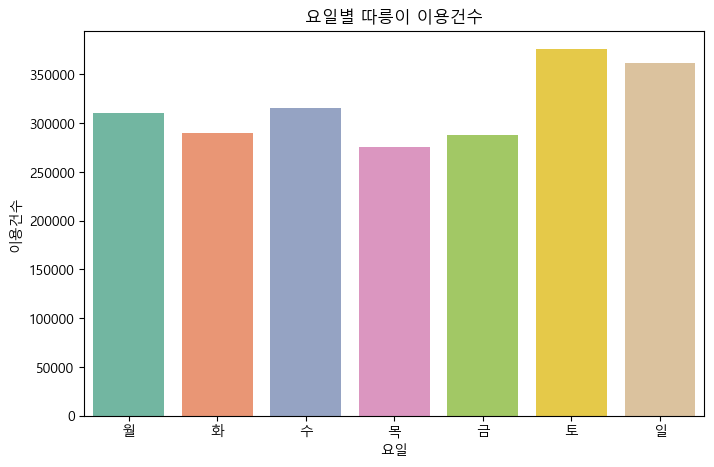

In [131]:
# 요일별 이용건수 barplot
plt.figure(figsize=(8,5))
sns.barplot(data=day_stats, x='요일', y='이용건수', palette='Set2', hue='요일', legend=False)
plt.title('요일별 따릉이 이용건수')
plt.xlabel('요일')
plt.ylabel('이용건수')
plt.show()

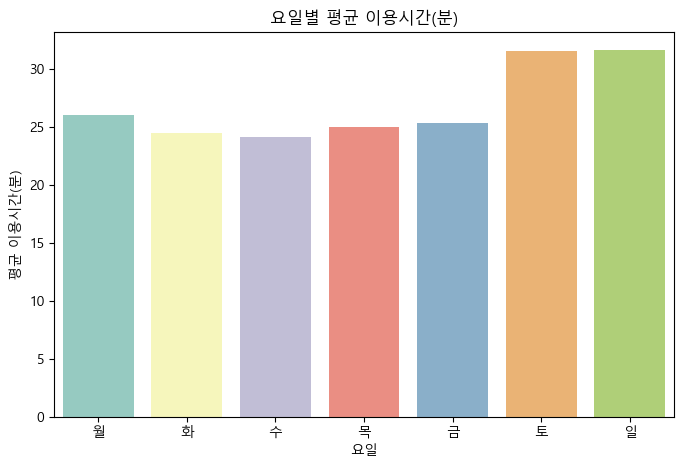

In [132]:
# 요일별 평균 이용시간 barplot
plt.figure(figsize=(8,5))
sns.barplot(data=day_stats, x='요일', y='평균이용시간', palette='Set3', hue='요일', legend=False)
plt.title('요일별 평균 이용시간(분)')
plt.xlabel('요일')
plt.ylabel('평균 이용시간(분)')
plt.show()

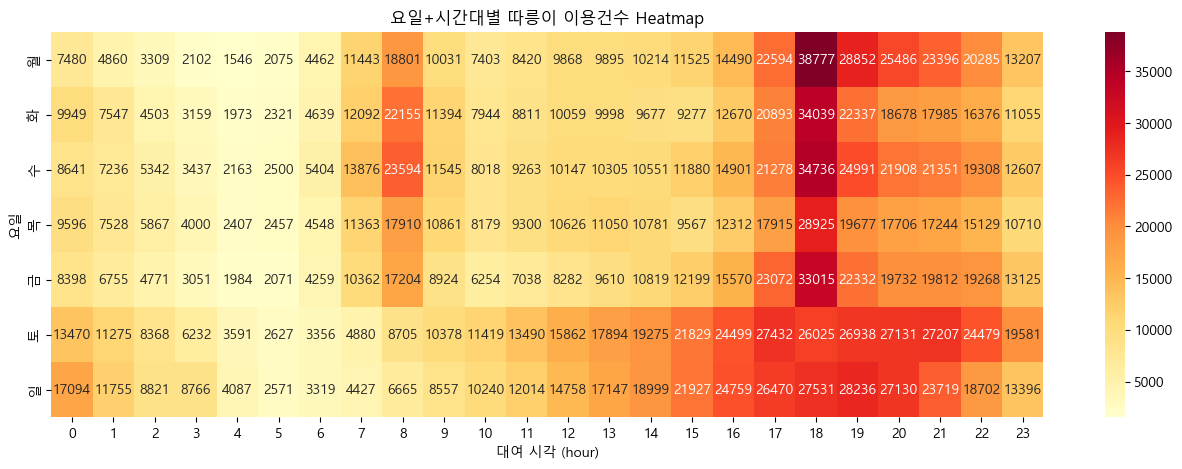

In [133]:
# 요일+시간대별 이용건수 피벗 테이블 및 heatmap
pivot_day_hour = rent_df.pivot_table(index='요일', columns='hour', values='대여일시', aggfunc='count', fill_value=0)
pivot_day_hour = pivot_day_hour.reindex(['월','화','수','목','금','토','일'])
plt.figure(figsize=(16,5))
sns.heatmap(pivot_day_hour, cmap='YlOrRd', annot=True, fmt='d')
plt.title('요일+시간대별 따릉이 이용건수 Heatmap')
plt.xlabel('대여 시각 (hour)')
plt.ylabel('요일')
plt.show()

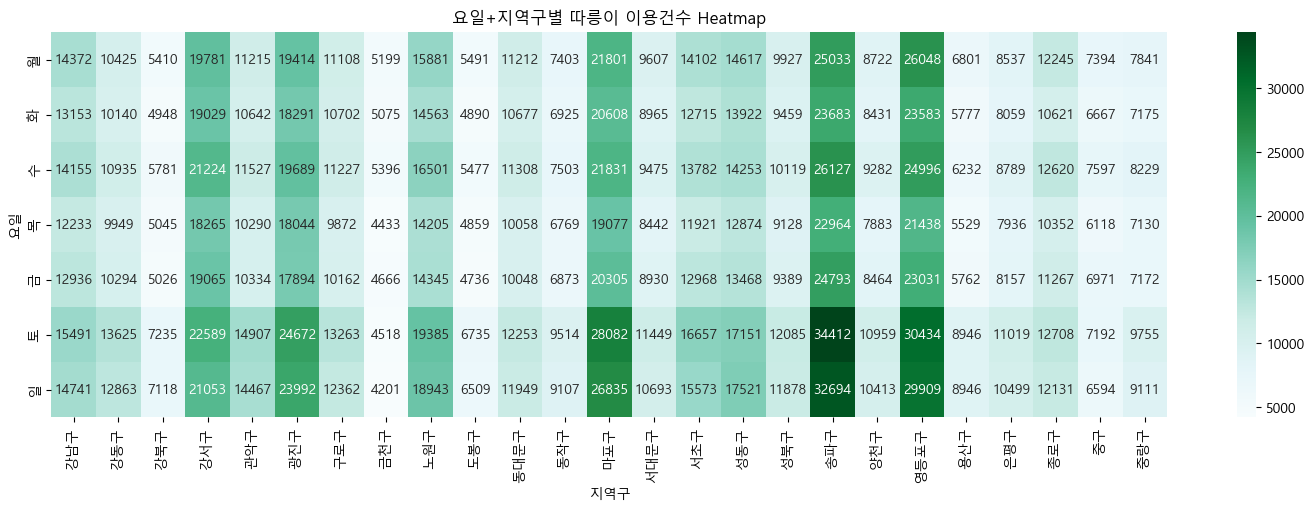

In [134]:
# 요일+지역구별 이용건수 피벗 테이블 및 heatmap
merged['요일'] = rent_df['요일']  # 병합 데이터에도 요일 컬럼 추가
day_gu_pivot = merged.pivot_table(index='요일', columns='지역구', values='대여일시', aggfunc='count', fill_value=0)
day_gu_pivot = day_gu_pivot.reindex(['월','화','수','목','금','토','일'])
plt.figure(figsize=(18,5))
sns.heatmap(day_gu_pivot, cmap='BuGn', annot=True, fmt='d')
plt.title('요일+지역구별 따릉이 이용건수 Heatmap')
plt.xlabel('지역구')
plt.ylabel('요일')
plt.show()

- 위 분석을 통해 요일별, 요일+시간대, 요일+지역구별 따릉이 이용 패턴을 시각적으로 확인할 수 있습니다.

## 6️⃣ 지역별 보유량 대비 이용량 및 이용률 순위 분석
- 각 지역구별 자전거 보유량(거치대수 합계)과 이용량(이용건수 합계)을 비교합니다.
- 보유량 대비 이용률(%)을 계산하고, 순위별로 시각화합니다.
- 상관계수(corr)로 보유량과 이용량의 관계도 확인합니다.

In [135]:
# 지역구별 자전거 보유량(거치대수 합계)
gu_bike_stock = location_df.groupby('지역구')['거치대수'].sum().reset_index().rename(columns={'거치대수':'보유량(거치대수)'})
# 지역구별 이용량(이용건수 합계)
gu_usage = merged.groupby('지역구')['대여일시'].count().reset_index().rename(columns={'대여일시':'이용량(이용건수)'})
# 병합
gu_stock_usage = pd.merge(gu_bike_stock, gu_usage, on='지역구', how='inner')
# 이용률(%) 계산 및 순위
# 0으로 나누는 경우 방지
import numpy as np
gu_stock_usage['이용률(%)'] = np.where(
    gu_stock_usage['보유량(거치대수)'] > 0,
    gu_stock_usage['이용량(이용건수)'] / gu_stock_usage['보유량(거치대수)'] * 100,
    np.nan
)
gu_stock_usage['이용률순위'] = gu_stock_usage['이용률(%)'].rank(ascending=False, method='min').astype(int)
gu_stock_usage = gu_stock_usage.sort_values('이용률(%)', ascending=False).reset_index(drop=True)
gu_stock_usage.head()

지역구  보유량(거치대수)  이용량(이용건수)        이용률(%)  이용률순위
0   광진구        793     141996  17906.179067      1
1   마포구       1062     158539  14928.342750      2
2   송파구       1279     189706  14832.369038      3
3  영등포구       1258     179439  14263.831479      4
4   강서구       1014     141006  13905.917160      5

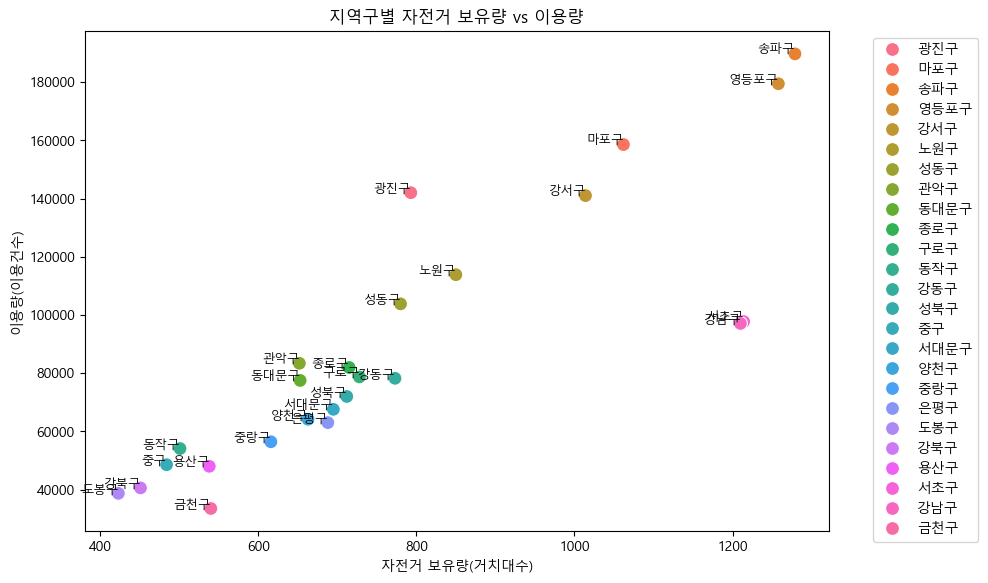

보유량-이용량 상관계수: 0.851


In [136]:
# 보유량 대비 이용량 산점도 및 상관계수
plt.figure(figsize=(10,6))
sns.scatterplot(data=gu_stock_usage, x='보유량(거치대수)', y='이용량(이용건수)', hue='지역구', s=100)
for i, row in gu_stock_usage.iterrows():
    plt.text(row['보유량(거치대수)'], row['이용량(이용건수)'], row['지역구'], fontsize=9, ha='right')
plt.title('지역구별 자전거 보유량 vs 이용량')
plt.xlabel('자전거 보유량(거치대수)')
plt.ylabel('이용량(이용건수)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

corr_value = gu_stock_usage[['보유량(거치대수)', '이용량(이용건수)']].corr().iloc[0,1]
print(f"보유량-이용량 상관계수: {corr_value:.3f}")

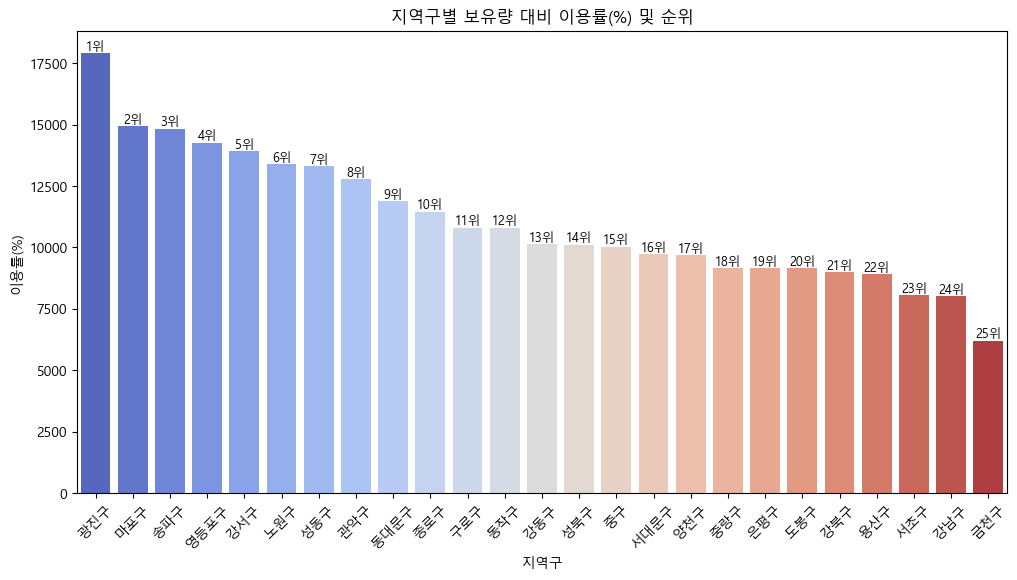

In [137]:
# 이용률(%) 순위 barplot
plt.figure(figsize=(12,6))
sns.barplot(data=gu_stock_usage, x='지역구', y='이용률(%)', order=gu_stock_usage['지역구'], palette='coolwarm', hue='지역구', legend=False)
for i, row in gu_stock_usage.iterrows():
    plt.text(i, row['이용률(%)']+0.5, f"{row['이용률순위']}위", ha='center', va='bottom', fontsize=9)
plt.title('지역구별 보유량 대비 이용률(%) 및 순위')
plt.xlabel('지역구')
plt.ylabel('이용률(%)')
plt.xticks(rotation=45)
plt.show()

- 이용률(%)이 높은 지역은 자전거를 더 늘릴 필요가 있고, 낮은 지역은 감축을 고려할 수 있습니다.
- 이용률 순위와 상관계수 모두 참고하여 정책적 결정을 내릴 수 있습니다.

## 7️⃣ Folium을 활용한 지역구별 보유량·이용량·이용률 Choropleth 지도 시각화
- 서울시 geojson(행정구역 경계)을 활용해 지역구별로 보유량, 이용량, 이용률(%)을 색상으로 시각화합니다.
- 마우스 오버/클릭 시 각 지역구의 상세 정보(보유량, 이용량, 이용률, 순위)를 팝업으로 제공합니다.

In [139]:
import json
with open('./data/seoul.json', encoding='utf-8') as f:
    seoul_geo = json.load(f)

m_choropleth = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# Choropleth 레이어 추가 (이용률 기준 색상, 경계선 강조)
choropleth = folium.Choropleth(
    geo_data=seoul_geo,
    data=gu_stock_usage,
    columns=['지역구', '이용률(%)'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.7,  # 경계선 강조
    line_color='black',
    nan_fill_color='lightgray',
    nan_fill_opacity=0.4,
    legend_name='지역구별 자전거 이용률(%)',
    highlight=True
).add_to(m_choropleth)

# 지역구별 정보를 dict로 준비
gu_popup_dict = {
    row['지역구']: (
        f"<b>{row['지역구']}</b><br>"
        f"보유량: {row['보유량(거치대수)']}<br>"
        f"이용량: {row['이용량(이용건수)']}<br>"
        f"이용률: {row['이용률(%)']:.1f}%<br>"
        f"순위: {row['이용률순위']}위"
    )
    for _, row in gu_stock_usage.iterrows()
}

# 각 지역구별로 올바른 팝업을 표시하도록 수정
def style_function(feature):
    return {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0
    }

def highlight_function(feature):
    return {'weight': 3, 'color': 'blue'}

for feature in seoul_geo['features']:
    gu_name = feature['properties']['name']
    popup_text = gu_popup_dict.get(gu_name, f"<b>{gu_name}</b><br>데이터 없음")
    folium.GeoJson(
        feature,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.Tooltip(popup_text, sticky=True)
    ).add_to(m_choropleth)

# LayerControl 추가
folium.LayerControl(collapsed=True).add_to(m_choropleth)

# 지도 저장 및 노트북에서 보기
m_choropleth.save('./data/bike_gu_choropleth_map.html')
from IPython.display import IFrame
IFrame('./data/bike_gu_choropleth_map.html', width=800, height=600)

m_choropleth

- 지역구별로 색상으로 보유량 대비 이용률(%)을 한눈에 확인할 수 있습니다.
- 마우스 오버/클릭 시 각 지역구의 상세 정보가 팝업으로 표시됩니다.
- 지도 하단의 legend(범례)를 통해 색상별 이용률(%)의 높고 낮음을 확인할 수 있습니다.